El área de marketing nos invita a una de sus reuniones internas donde exponen entre otras cosas
que el área de retención de la compañía ha detectado un aumento continuado en los últimos meses de las bajas de 
los clientes de seguro de autos y para mitigarlo quieren hacer una campaña donde se le envía un incentivo a los clientes
que vayan a renovar, pero el presupuesto es limitado.

Para ayudarles a determinar a qué clientes merece la pena retener, les proponemos hacer un modelo predictivo.

# Ejercicio 1

Para este ejercicio, como integrante del área de Advanced Analytics tienes que analizar la BBDD para comprender los factores
que afectan a la fuga de clientes. El objetivo es definir el problema, llevar a cabo tareas de data wrangling, ingeniería de variables,
análisis exploratorio proporcionando ideas y conclusiones y por último explorar diferentes técnicas de modelización, eligiendo la mejor y comentando resultados.

Nuestro objetivo será desarrollar un modelo de **clasificación binaria** que nos ayude a conocer aquellos clientes que tengan mayor probabilidad de anular su póliza y poder tomar medidas para evitarlo, en este caso, enviando un incentivo económico. 

También se ha de tener en cuenta que el presupuesto de los incentivos es **limitado**, por lo que habrá que seleccionar aquellos clientes que sean mas rentables para la compañía.

En primer lugar, cargamos todas las librerías necesarias para desarrollar el análisis de los datos y el modelaje

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import norm
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from yellowbrick.classifier import confusion_matrix, precision_recall_curve
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.model_selection import FeatureImportances
import shap
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from scipy.stats import randint, uniform, loguniform
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

Para este ejercicio disponemos de dos datasets, el primero con la información de las pólizas y el segundo con información sociodemográfica de los clientes

Cargamos el primer dataset y hacemos una primera visualización de las variables que contiene, así como su formato y tamaño:

In [2]:
df_polizas = pd.read_csv('/home/dell/Descargas/Prueba/BBDD_anulaciones.tab', delimiter='\t', encoding='latin1')

In [3]:
df_polizas.head()

,id_poliza,anula,edad_cliente,cia_procedencia,antig_cliente,garantia_ampliada,canal_entrada,prima,profesion,VC,...,pvp_vehiculo,siniestros_ultimo_anyo,Polizas_AUTO,Importe_siniestros,admite_publi,id_agente_gestor,tipo_pago,CV_coche,Gestion_multas,codigo_zona
0,1,0,27.4,Ocaso,0.00,Vehiculo sustitucion,NaN,90.30,Transporte de mercan,NaN,...,10457.084954,0,0,0.000000,Si,24,Mensual,47.0,N,483.0
1,2,0,24.9,Mutua Madrileña,4.49,Vehiculo sustitucion,Oficina Adeslas,194.06,Transporte de mercan,NaN,...,12078.987975,1,0,268.834435,Si,21,Anual,61.0,N,832.0
2,3,0,37.4,Liberty,0.00,Vehiculo sustitucion,Oficina Adeslas,186.04,Desconocido,NaN,...,7049.969489,1,1,2.504393,.,17,Mensual,112.0,N,256.0
3,4,0,19.8,Mutua Madrileña,8.45,Vehiculo sustitucion,Telefonico,128.71,Logistica,NaN,...,7097.456241,1,3,60.670131,.,90,Anual,104.0,N,627.0
4,5,0,35.6,Ocaso,NaN,Vehiculo sustitucion,Telefonico,357.16,Estudiante,NaN,...,24563.357655,0,3,0.000000,No,72,Anual,NaN,N,654.0


In [4]:
df_polizas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_poliza               50000 non-null  int64  
 1   anula                   50000 non-null  int64  
 2   edad_cliente            47999 non-null  float64
 3   cia_procedencia         47936 non-null  object 
 4   antig_cliente           44998 non-null  float64
 5   garantia_ampliada       50000 non-null  object 
 6   canal_entrada           49999 non-null  object 
 7   prima                   50000 non-null  float64
 8   profesion               50000 non-null  object 
 9   VC                      0 non-null      float64
 10  antiguedad_vehiculo     50000 non-null  object 
 11  pvp_vehiculo            42988 non-null  float64
 12  siniestros_ultimo_anyo  50000 non-null  int64  
 13  Polizas_AUTO            50000 non-null  int64  
 14  Importe_siniestros      50000 non-null

Podemos observar que el dataframe contiene 50.000 filas y 21 columnas, algunas de ellas con valores nulos e incluso una de ellas con todos sus valores nulos por lo que no nos aporta ninguna información útil para el modelo.

Veamos la distribución de la variable dependiente:

In [5]:
df_polizas.groupby('anula').size()/df_polizas.shape[0]*100

anula
0    97.998
1     2.002
dtype: float64

Comprobamos que las clases están muy **desbalanceadas**, ya que los usuarios que anulan su póliza representan solo el 2% del total de la muestra.

Cargamos el dataframe con los datos sociodemográficos y repetimos el proceso

In [6]:
df_zonas = pd.read_csv('/home/dell/Descargas/Prueba/BBDD_extra.tab', delimiter='\t', encoding='latin1')

In [7]:
df_zonas.head(10)

,codigo_zona,NUM_FAMILIAS,NUM_PERSONAS,NUM_PERSONAS_POR_FAMILIA,CAPITAL_PROVINCIA,TAMANO_MUNICIPIO,SUPERFICIE,DENSIDAD_POBLACION,ROOMMATES_PCT,ROOMMATES_TOTAL,...,NUM_INMUEBLES_SUELO_ALQ,PROMED_M2_INMUEBLES_SUELO_ALQ,PRECIO_INMUEBLES_TRAST_COMP,PRECIO_M2_TRAST_COMP,NUM_INMUEBLES_TRAST_COMP,PROMED_M2_INMUEBLES_TRAST_COMP,PRECIO_INMUEBLES_TRAST_ALQ,PRECIO_M2_TRAST_ALQ,NUM_INMUEBLES_TRAST_ALQ,PROMED_M2_INMUEBLES_TRAST_ALQ
0,1,5534,17531,3.17,1,1,1187,1476.4,0.095,524,...,11,3283.88,11845.70,2547.17,249,21.69,73.50,13.19,274,10.42
1,10,1443,3528,2.44,0,5,12952,27.2,0.047,68,...,13,2010.69,10862.15,1209.68,65,9.98,81.05,13.50,61,10.44
2,1002,336,651,1.94,0,5,2533,25.7,0.017,6,...,2,1644.00,3014.29,415.23,16,9.19,92.05,10.32,16,20.25
3,1011,160,331,2.07,0,5,4342,7.6,0.026,4,...,2,2585.75,4261.11,662.26,14,7.19,92.31,8.84,14,21.77
4,1012,1278,3237,2.53,1,1,1238,261.4,0.058,95,...,3,727.78,10776.98,2084.45,53,28.26,65.00,10.48,58,9.22
5,1014,17,39,2.28,0,5,967,4.1,0.082,1,...,0,220.00,11714.24,2113.44,2,15.48,85.10,9.19,2,29.65
6,1016,185,468,2.53,0,5,3736,12.5,0.073,14,...,2,2140.60,4225.93,676.55,10,6.85,87.96,9.71,10,18.19
7,1018,671,1819,2.71,0,4,527,345.3,0.104,70,...,3,1815.33,3268.00,1301.06,25,10.64,476.63,85.72,19,21.16
8,1019,5552,13704,2.47,0,3,1337,1025.2,0.069,385,...,14,1295.57,10990.98,2922.27,133,10.19,83.39,12.26,122,11.01
9,1020,230,586,2.55,0,5,1418,41.3,0.051,12,...,6,5467.83,14106.40,2125.06,25,10.00,107.60,18.65,20,10.85


In [8]:
df_zonas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Columns: 400 entries, codigo_zona to PROMED_M2_INMUEBLES_TRAST_ALQ
dtypes: float64(297), int64(103)
memory usage: 928.2 KB


Observamos que el dataframe contiene 297 filas y 400 variables, de las cuales la mayoría no tienen, a priori, un impacto en la decisión de un cliente de anular su póliza. Por tanto, para reducir la complejidad del modelo y evitar sobreajuste nos quedaremos únicamente con 4 variables: personas/familia, tamaño del municipio, densidad de población y capital de provincia.

Mergeamos con nuestro dataset anterior mediante la variable *codigo_zona*

In [9]:
df_zonas_merge = df_zonas[['codigo_zona', 'NUM_PERSONAS_POR_FAMILIA', 'CAPITAL_PROVINCIA', 'TAMANO_MUNICIPIO', 'DENSIDAD_POBLACION']]

In [10]:
df = df_polizas.merge(df_zonas_merge, how='left', on='codigo_zona')

In [11]:
df.head()

,id_poliza,anula,edad_cliente,cia_procedencia,antig_cliente,garantia_ampliada,canal_entrada,prima,profesion,VC,...,admite_publi,id_agente_gestor,tipo_pago,CV_coche,Gestion_multas,codigo_zona,NUM_PERSONAS_POR_FAMILIA,CAPITAL_PROVINCIA,TAMANO_MUNICIPIO,DENSIDAD_POBLACION
0,1,0,27.4,Ocaso,0.00,Vehiculo sustitucion,NaN,90.30,Transporte de mercan,NaN,...,Si,24,Mensual,47.0,N,483.0,1.94,0.0,5.0,4.0
1,2,0,24.9,Mutua Madrileña,4.49,Vehiculo sustitucion,Oficina Adeslas,194.06,Transporte de mercan,NaN,...,Si,21,Anual,61.0,N,832.0,2.23,0.0,5.0,2.6
2,3,0,37.4,Liberty,0.00,Vehiculo sustitucion,Oficina Adeslas,186.04,Desconocido,NaN,...,.,17,Mensual,112.0,N,256.0,2.12,0.0,5.0,5.1
3,4,0,19.8,Mutua Madrileña,8.45,Vehiculo sustitucion,Telefonico,128.71,Logistica,NaN,...,.,90,Anual,104.0,N,627.0,2.75,0.0,5.0,211.5
4,5,0,35.6,Ocaso,NaN,Vehiculo sustitucion,Telefonico,357.16,Estudiante,NaN,...,No,72,Anual,NaN,N,654.0,2.45,0.0,5.0,13.3


Ya tenemos el dataset con todas las variables que utilizaremos para el modelo. A continuación debemos realizar tarea de data wrangling, feature engineering, eliminación de outliers y tratamiento de datos nulos para poder ingestar los datos en nuestro modelo de clasificación.

Por un lado trataremos las variables de tipo numérico y por otro lado las de tipo categórico:

### Data wrangling

#### Variables numéricas

Eliminamos las variables que no aportan información útil y seleccionamos únicamente las variables numéricas

In [12]:
df = df.drop(columns=['VC', 'id_agente_gestor', 'codigo_zona'])

In [13]:
df_num = df[['edad_cliente', 'antig_cliente', 'prima', 'pvp_vehiculo', 'siniestros_ultimo_anyo', 
             'Polizas_AUTO', 'Importe_siniestros', 'CV_coche', 'NUM_PERSONAS_POR_FAMILIA', 'DENSIDAD_POBLACION', 'id_poliza']]

Sustituimos los valores nulos por la **mediana** de la variable correspondiente para evitar el sesgo que puedan provocar los datos extremos. Si la variable contiene muchos datos nulos la mejor opción es eliminarla.

In [14]:
df_num['edad_cliente'].fillna(df_num['edad_cliente'].median(), inplace=True)
df_num['antig_cliente'].fillna(df_num['antig_cliente'].median(), inplace=True)
df_num['pvp_vehiculo'].fillna(df_num['pvp_vehiculo'].median(), inplace=True)
df_num['CV_coche'].fillna(df_num['CV_coche'].median(), inplace=True)
df_num['NUM_PERSONAS_POR_FAMILIA'].fillna(df_num['NUM_PERSONAS_POR_FAMILIA'].median(), inplace=True)
df_num['DENSIDAD_POBLACION'].fillna(df_num['DENSIDAD_POBLACION'].median(), inplace=True)

Ahora que no tenemos datos nulos, podemos realizar una resumen estadístico del dataframe

In [15]:
df_num.describe()

,edad_cliente,antig_cliente,prima,pvp_vehiculo,siniestros_ultimo_anyo,Polizas_AUTO,Importe_siniestros,CV_coche,NUM_PERSONAS_POR_FAMILIA,DENSIDAD_POBLACION,id_poliza
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,31.123832,8.234348,381.369962,8656.144016,1.012600,0.745380,68.822230,69.139020,2.484807,995.254766,25000.500000
std,11.560583,7.562757,328.523591,6564.864512,1.002547,0.864941,79.249168,59.502995,0.273382,3155.824253,14433.901067
min,18.000000,0.000000,0.030000,0.142296,0.000000,0.000000,0.000000,0.000000,1.770000,0.700000,1.000000
25%,24.800000,1.090000,144.570000,4080.573736,0.000000,0.000000,3.360795,36.000000,2.300000,10.800000,12500.750000
50%,29.900000,6.940000,289.590000,7315.355145,1.000000,1.000000,42.782028,55.000000,2.490000,37.400000,25000.500000
75%,34.700000,12.800000,520.302500,11484.416075,2.000000,1.000000,104.103601,79.000000,2.660000,205.400000,37500.250000
max,125.000000,48.300000,3900.690000,75734.903519,7.000000,6.000000,791.968944,754.000000,3.280000,33162.800000,50000.000000


Veamos ahora cómo tratar los outliers, representando gráficos de boxplot para ver como se distribuyen los datos de las variables

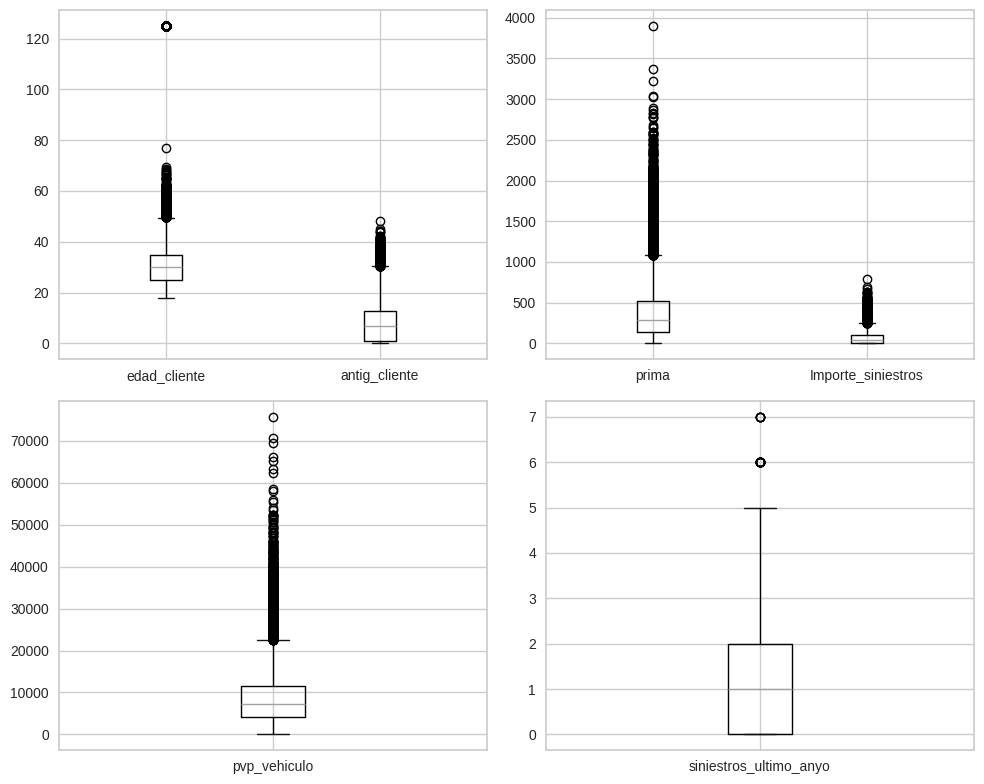

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8)) 
boxplot = df_num.boxplot(column=['edad_cliente', 'antig_cliente'], ax=axes[0, 0])
boxplot = df_num.boxplot(column=['prima', 'Importe_siniestros'], ax=axes[0, 1]) 
boxplot = df_num.boxplot(column=['pvp_vehiculo'], ax=axes[1, 0]) 
boxplot = df_num.boxplot(column=['siniestros_ultimo_anyo'], ax=axes[1, 1]) 
plt.tight_layout()
plt.show()

Vemos que existen datos atípicos en muchas de las variables, pero en este caso no las eliminaremos ya que podrían aportar información útil al modelo que ayude a clasificar a clientes con mayor riesgo de fuga. En caso de eliminarlos, el criterio seguido es eliminar aquellos valores mayores que Q3+1.5xIQR o inferiores a Q1-1.5xIQR, donde IQR es el rango intercuartílico entre Q1 y Q3.

Lo que sí debemos eliminar son valores absurdos de variables como edad_cliente mayores de 90 años o aquéllos en los que antig_cliente > edad_cliente

In [17]:
df_num=df_num.loc[(df_num.edad_cliente<80)&(df_num.edad_cliente>=df_num.antig_cliente)]

Añadimos la variable objetivo para poder analizar la relación entre ésta y las variables independientes

In [19]:
df_num_tg = df_num.merge(df[['anula', 'id_poliza']], how='left', on='id_poliza')

In [20]:
df_num_tg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48411 entries, 0 to 48410
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad_cliente              48411 non-null  float64
 1   antig_cliente             48411 non-null  float64
 2   prima                     48411 non-null  float64
 3   pvp_vehiculo              48411 non-null  float64
 4   siniestros_ultimo_anyo    48411 non-null  int64  
 5   Polizas_AUTO              48411 non-null  int64  
 6   Importe_siniestros        48411 non-null  float64
 7   CV_coche                  48411 non-null  float64
 8   NUM_PERSONAS_POR_FAMILIA  48411 non-null  float64
 9   DENSIDAD_POBLACION        48411 non-null  float64
 10  id_poliza                 48411 non-null  int64  
 11  anula                     48411 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 4.4 MB


#### Variables categóricas

Seleccionamos las variables categóricas de nuestro dataset

In [21]:
df_cat = df[['cia_procedencia', 'garantia_ampliada', 'canal_entrada', 'profesion', 'admite_publi', 'tipo_pago', 
             'Gestion_multas', 'CAPITAL_PROVINCIA', 'TAMANO_MUNICIPIO', 'antiguedad_vehiculo', 'id_poliza']]

En la variable antig_vehículo las categorías están desbalanceadas por lo que las agrupamos

In [22]:
# Sustituimos valores inválidos
df_cat['antiguedad_vehiculo'] = df_cat['antiguedad_vehiculo'].replace('**', np.nan).astype(float)

# Definimos rangos y etiquetas
bins = [-1, 2, 5, 9, 12, np.inf]  
labels = ['Nuevo', 'Reciente', 'Usado', 'Antiguo', 'Muy Antiguo']

df_cat['antiguedad_vehiculo'] = pd.cut(df_cat['antiguedad_vehiculo'], bins=bins, labels=labels)

print(df_cat['antiguedad_vehiculo'].value_counts())

antiguedad_vehiculo
Usado          15884
Reciente       14059
Nuevo          13226
Antiguo         4890
Muy Antiguo     1464
Name: count, dtype: int64


In [23]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   cia_procedencia      47936 non-null  object  
 1   garantia_ampliada    50000 non-null  object  
 2   canal_entrada        49999 non-null  object  
 3   profesion            50000 non-null  object  
 4   admite_publi         50000 non-null  object  
 5   tipo_pago            50000 non-null  object  
 6   Gestion_multas       49028 non-null  object  
 7   CAPITAL_PROVINCIA    49364 non-null  float64 
 8   TAMANO_MUNICIPIO     49364 non-null  float64 
 9   antiguedad_vehiculo  49523 non-null  category
 10  id_poliza            50000 non-null  int64   
dtypes: category(1), float64(2), int64(1), object(7)
memory usage: 3.9+ MB


En el caso de las variables categóricas sustituimos los valores nulos por la **moda** de la variable correspondiente

In [24]:
df_cat['cia_procedencia']=df_cat['cia_procedencia'].fillna(df_cat['cia_procedencia'].mode()[0])
df_cat['canal_entrada']=df_cat['canal_entrada'].fillna(df_cat['canal_entrada'].mode()[0])
df_cat['Gestion_multas']=df_cat['Gestion_multas'].fillna(df_cat['Gestion_multas'].mode()[0])
df_cat['CAPITAL_PROVINCIA']=df_cat['CAPITAL_PROVINCIA'].fillna(df_cat['CAPITAL_PROVINCIA'].mode()[0])
df_cat['TAMANO_MUNICIPIO']=df_cat['TAMANO_MUNICIPIO'].fillna(df_cat['TAMANO_MUNICIPIO'].mode()[0])
df_cat['antiguedad_vehiculo']=df_cat['antiguedad_vehiculo'].fillna(df_cat['antiguedad_vehiculo'].mode()[0])

Corregimos los errores tipográficos encontrados en algunas categorías

In [25]:
correcciones = {
    'Banc0': 'Banco',  
    'Banca': 'Banco', 
    'Estdiante': 'Estudiante',
    'Medicina/Enfermería': 'Medicina/Enfermeria',
    'Minería': 'Mineria',
}

df_cat['profesion'] = df_cat['profesion'].replace(correcciones)

In [26]:
mapeo_profesiones = {
    'Administrativo': 'administrativo_funcionario',
    'Funcion publica': 'administrativo_funcionario',
    'Oficial de primera': 'administrativo_funcionario',
    'Informatico': 'tecnologia_ingenieria',
    'Ingeniero': 'tecnologia_ingenieria',
    'Logistica': 'tecnologia_ingenieria',
    'Investigador': 'docencia_investigacion',
    'Profesor/Docencia': 'docencia_investigacion',
    'Transporte de mercan': 'transporte',
    'Transporte de pasaje': 'transporte',
    'Limpieza': 'limpieza_hogar',
    'Labores del hogar': 'limpieza_hogar',
    'Mineria': 'desconocido_otros',
    'En paro': 'desempleo_estudiantes',
    'Desconocido': 'desconocido_otros',
    'Estudiante': 'desempleo_estudiantes'
}

# Reemplazar en el df
df_cat['profesion'] = df_cat['profesion'].replace(mapeo_profesiones)

# Verificar el resultado
print(df_cat['profesion'].value_counts())

profesion
administrativo_funcionario    11900
desempleo_estudiantes         10158
transporte                     8863
Banco                          3878
tecnologia_ingenieria          3738
limpieza_hogar                 3723
desconocido_otros              2736
docencia_investigacion         2534
Medicina/Enfermeria            2470
Name: count, dtype: int64


In [27]:
correcciones = {
    'Mutua Madrilenya': 'Mutua_Madrileña', 
    'Mutua Madrileña': 'Mutua_Madrileña', 
    'Union alcoyana': 'Union_alcoyana', 
    
}

df_cat['cia_procedencia'] = df_cat['cia_procedencia'].replace(correcciones)

In [28]:
correcciones = {
    'Telfonico': 'Telefonico',  
    'Oficina Adelsas': 'Oficina_Adeslas',
    'Oficina Adeslas': 'Oficina_Adeslas'
}

df_cat['canal_entrada'] = df_cat['canal_entrada'].replace(correcciones)

In [29]:
correcciones = {
    'Vehiculo sustitucion': 'vehiculo_sust',  
}

df_cat['garantia_ampliada'] = df_cat['garantia_ampliada'].replace(correcciones)

In [30]:
correcciones = {
    ' .': 'desc',  
}

df_cat['admite_publi'] = df_cat['admite_publi'].replace(correcciones)

In [31]:
df_cat_tg = df_cat.merge(df[['id_poliza', 'anula']], how='left', on='id_poliza')

Transformamos las variables categóricas a numéricas mediante one-hot encoding permitiendo así su ingesta al modelo y evitando interpretaciones erróneas sobre la importancia o el orden de las categorías.

La desventaja es que para variables con muchas categorías, se añaden muchas columnas al dataset aumentando la complejidad del modelo y el riesgo de overfitting.

In [32]:
df_cat_encoded = pd.get_dummies(df_cat, columns=['profesion', 'cia_procedencia', 'canal_entrada', 'garantia_ampliada', 'tipo_pago', 
                                         'admite_publi', 'Gestion_multas', 'antiguedad_vehiculo'], drop_first=True, dtype=float)

In [33]:
df_cat_encoded.head()

,CAPITAL_PROVINCIA,TAMANO_MUNICIPIO,id_poliza,profesion_Medicina/Enfermeria,profesion_administrativo_funcionario,profesion_desconocido_otros,profesion_desempleo_estudiantes,profesion_docencia_investigacion,profesion_limpieza_hogar,profesion_tecnologia_ingenieria,...,canal_entrada_Telefonico,garantia_ampliada_vehiculo_sust,tipo_pago_Mensual,admite_publi_Si,admite_publi_desc,Gestion_multas_S,antiguedad_vehiculo_Reciente,antiguedad_vehiculo_Usado,antiguedad_vehiculo_Antiguo,antiguedad_vehiculo_Muy Antiguo
0,0.0,5.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,5.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,5.0,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,5.0,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,5.0,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Análisis exploratorio

#### Variables numéricas

Realizamos el análisis univariante de las algunas de las variables numéricas de nuestro dataset para estudiar cómo están distribuidas

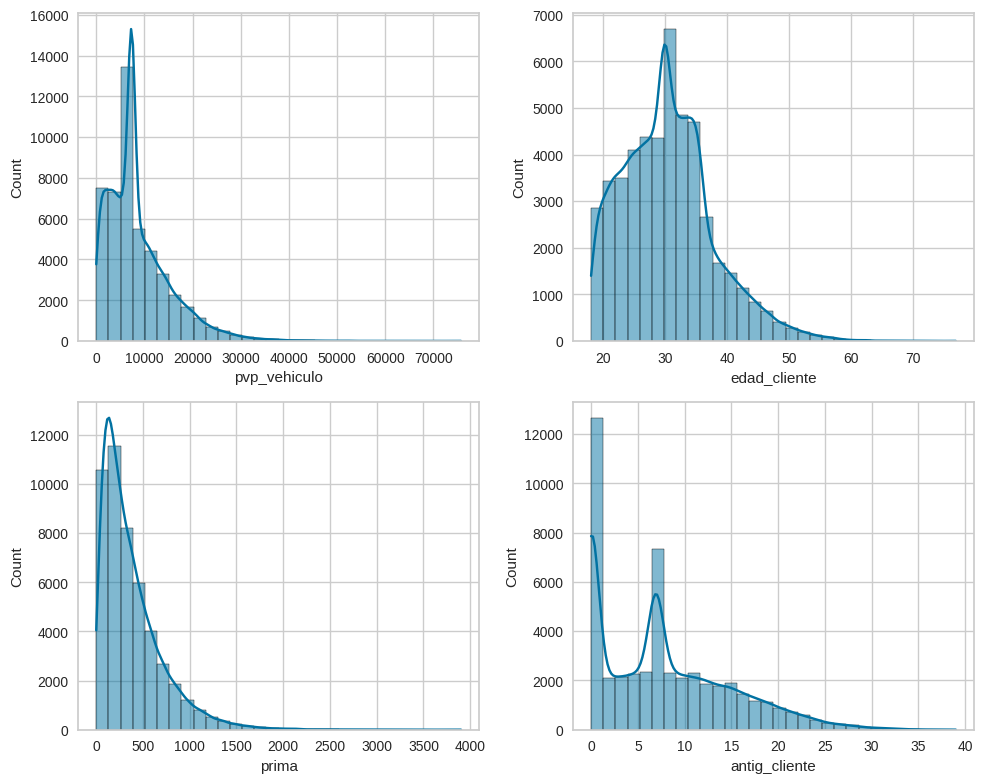

In [34]:
# Histogramas y funciones de densidad
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8)) 
sns.histplot(df_num['pvp_vehiculo'], bins=30, kde=True, ax=axes[0, 0])
sns.histplot(df_num['edad_cliente'], bins=30, kde=True, ax=axes[0, 1])
sns.histplot(df_num['prima'], bins=30, kde=True, ax=axes[1, 0])
sns.histplot(df_num['antig_cliente'], bins=30, kde=True, ax=axes[1, 1])
plt.tight_layout()
plt.show()

Observamos que la mayoria de primas son inferiores a 500€, la edad de los clientes se distribye entre los 20 y 40 años y son mas numerosos los clientes nuevos o con poca antigüedad.

Y cómo se distribuyen para cada una de las clases de la variable objetivo

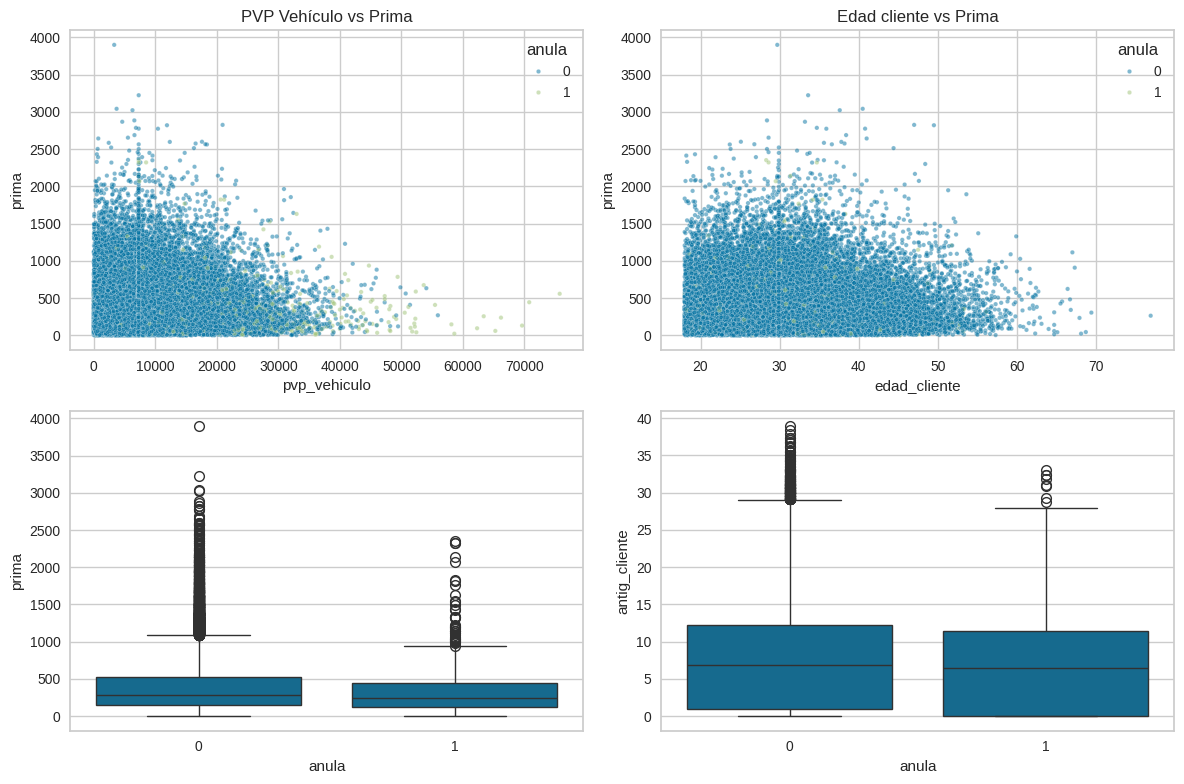

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))


sns.scatterplot(x='pvp_vehiculo', y='prima', data=df_num_tg, s=10, hue='anula', alpha=0.5, ax=axes[0, 0])
axes[0, 0].set_title('PVP Vehículo vs Prima')

sns.scatterplot(x='edad_cliente', y='prima', data=df_num_tg, s=10, hue='anula', alpha=0.5, ax=axes[0, 1])
axes[0, 1].set_title('Edad cliente vs Prima')

sns.boxplot(x=df_num_tg['anula'], y=df_num_tg['prima'], ax=axes[1, 0])
sns.boxplot(x=df_num_tg['anula'], y=df_num_tg['antig_cliente'], ax=axes[1, 1])


plt.tight_layout()
plt.show()

No observamos una correlación clara entre la prima y el precio del vehículo o entre la prima y la edad del cliente para niguna de las dos clases de la variable dependiente.

Por otro lado, los gráficos de boxplot no muestras diferencias significativas en la distribución de los valores de las primas y la antigüedad de los clientes entre aquellos que anulan su póliza y los que no.

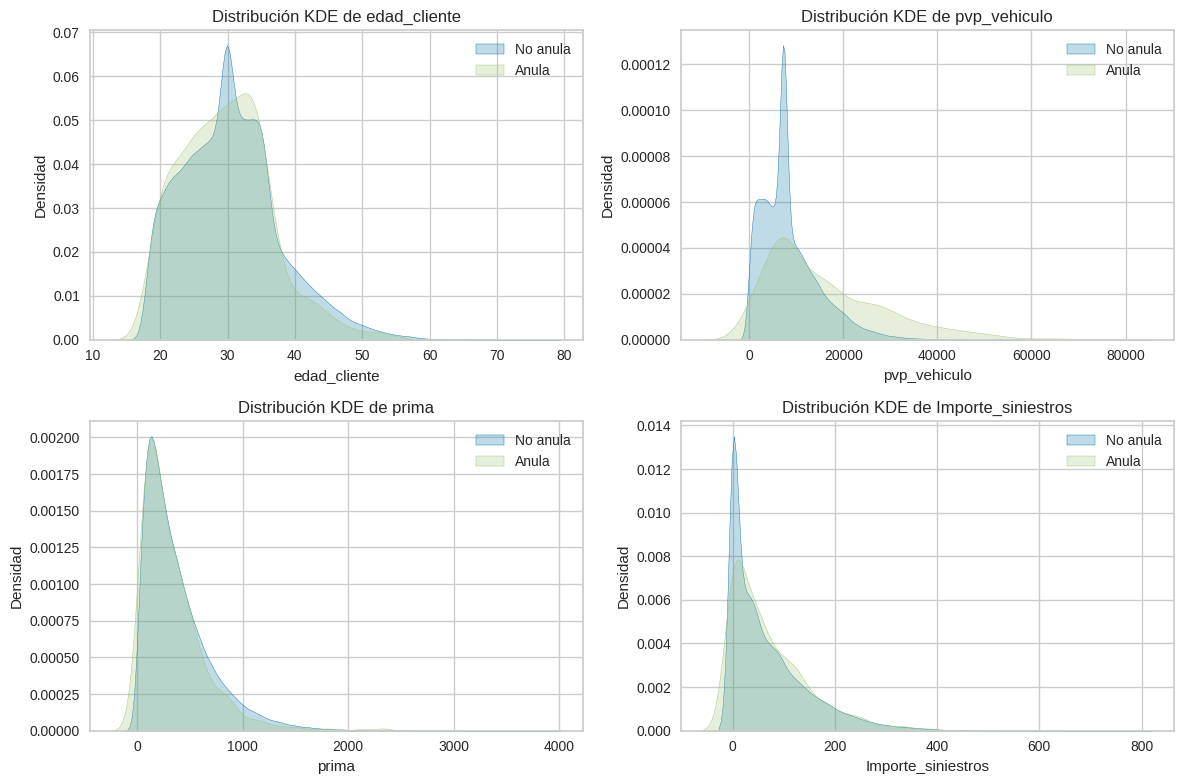

In [37]:
# Comparativas de la función de densidad contra la variable target para diversas variables
variables = ['edad_cliente', 'pvp_vehiculo', 'prima', 'Importe_siniestros']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()


for i, var in enumerate(variables):
    sns.kdeplot(df_num_tg[df_num_tg['anula'] == 0][var], label='No anula', shade=True, ax=axes[i])
    sns.kdeplot(df_num_tg[df_num_tg['anula'] == 1][var], label='Anula', shade=True, ax=axes[i])
    
    
    axes[i].set_title(f'Distribución KDE de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Densidad')
    axes[i].legend()


plt.tight_layout()
plt.show()

Podemos observar que la edad de los clientes que anulan tiende a ser ligeramente superior, el precio de sus vehículos tiene mayor varianza. 
Los clientes que anulan también tienden a tener mayor variabilidad en el importe en los siniestros.

Veamos la matriz de correlación de las variables para ver si existe multicolinealidad entre algunas de ellas

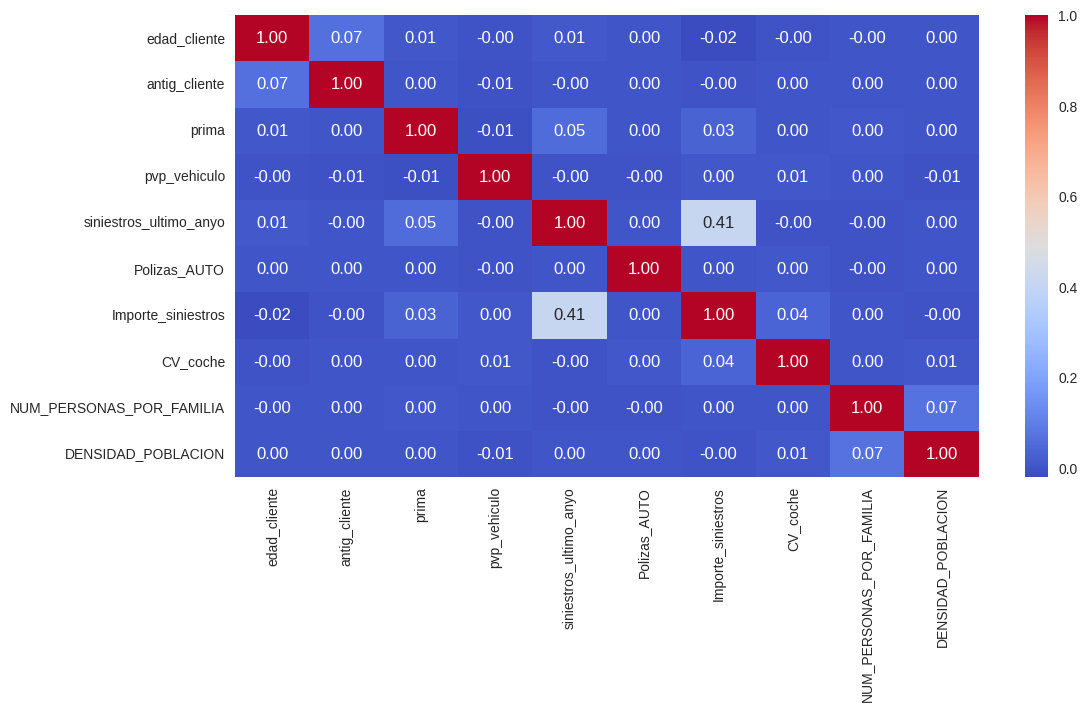

In [38]:
plt.figure(figsize=(12,6))
sns.heatmap(df_num.drop(columns=['id_poliza']).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

No se observa que exista una correlación siginificativa entre ninguna de ellas.

#### Variables categóricas

Veamos cómo se distribuyen por categorías algunas de ellas

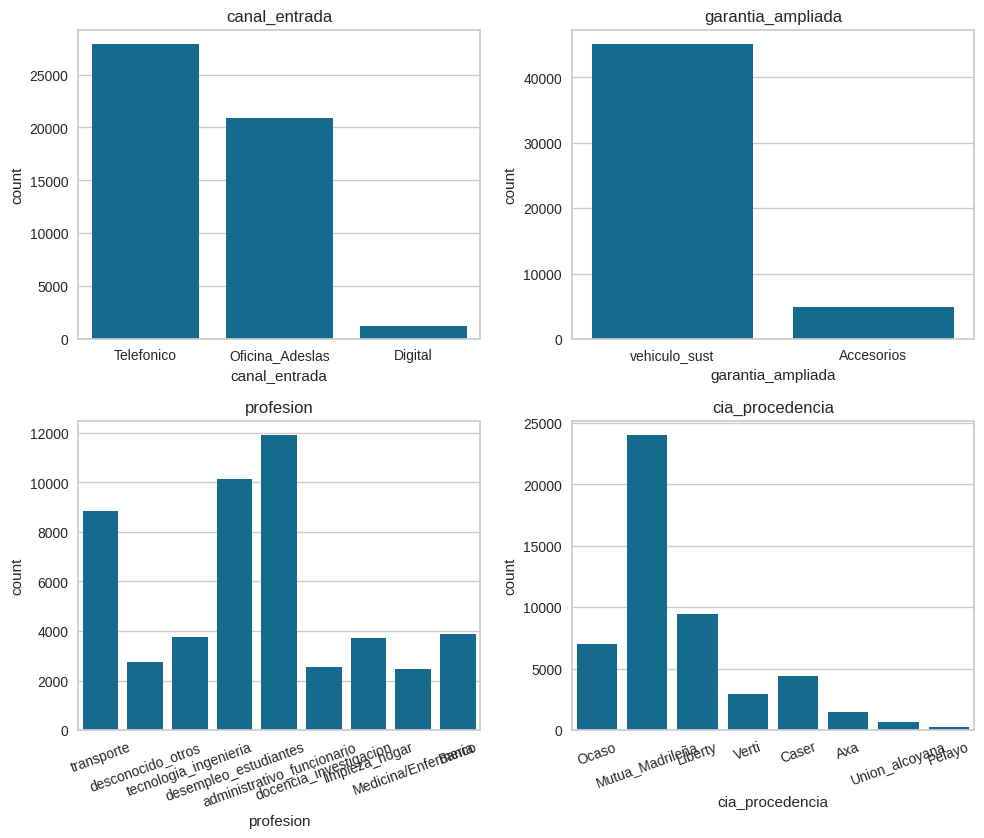

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))


sns.countplot(x='profesion', data=df_cat, ax=axes[1, 0])
axes[1, 0].set_title('profesion')


sns.countplot(x='cia_procedencia', data=df_cat, ax=axes[1, 1])
axes[1, 1].set_title('cia_procedencia')


sns.countplot(x='canal_entrada', data=df_cat, ax=axes[0, 0])
axes[0, 0].set_title('canal_entrada')


sns.countplot(x='garantia_ampliada', data=df_cat, ax=axes[0, 1])
axes[0, 1].set_title('garantia_ampliada')


plt.tight_layout()
plt.sca(axes[1, 0])  
plt.xticks(rotation=20) 
plt.sca(axes[1, 1])  
plt.xticks(rotation=20) 

plt.show()

Y la distribución agrupada por clase de la variable dependiente

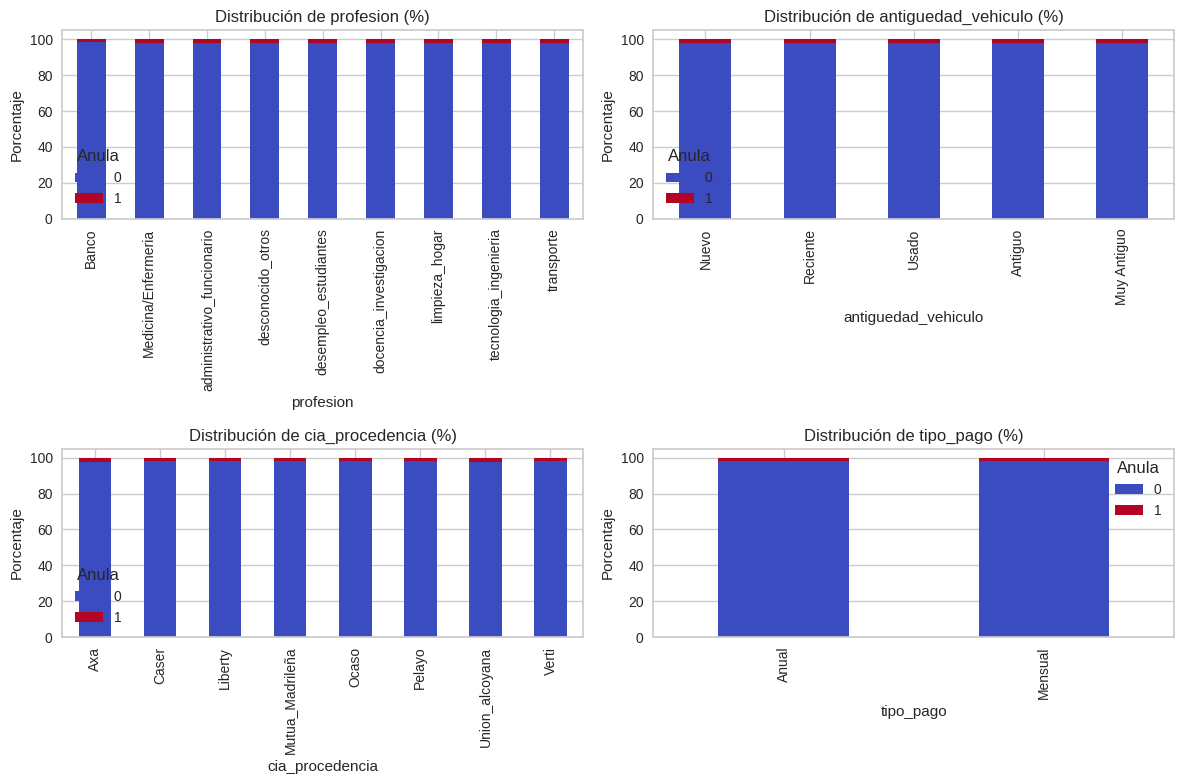

In [41]:
categorical_vars = ['profesion', 'antiguedad_vehiculo', 'cia_procedencia', 'tipo_pago']


fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    
    crosstab_norm = pd.crosstab(df_cat_tg[var], df_cat_tg['anula'], normalize="index") * 100
    crosstab_norm.plot(kind='bar', stacked=True, ax=axes[i], colormap='coolwarm')
   
    axes[i].set_title(f'Distribución de {var} (%)')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Porcentaje')
    axes[i].legend(title='Anula', loc='best')


plt.tight_layout()
plt.show()

Al existir un desbalanceo en las clases, no se observa una diferencia significativa en las agrupaciones de las categorías para los clientes que anulan su póliza.

### Modelos

Incluimos la variable objetivo en el dataframe que utilizaremos para entrenar los modelos

In [42]:
df_tg = df_num_tg.merge(df_cat_encoded, how='left', on='id_poliza')

Probaremos varios modelos de clasificación, comparando sus métricas para ver cuál tiene mejor rendimiento y porqué.

Separamos la variable dependiente del dataset que utilizaremos para entrenar y lo dividimos en un conjunto de entramiento y otro de test (80%-20%). Estratificamos las muestras para que se mantangan las proporciones de las clases de la variable objetivo en ambos conjuntos.

In [43]:
X = df_tg.drop(columns=['anula', 'id_poliza'])
y = df_tg['anula']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Randon Forest

Para entrenar el modelo y elegir los hiperparámetros óptimos utilizaremos la técnica de validación cruzada con búsqueda en aleatorizada. De esta forma nos evitamos probar todas las posibles combinaciones, acelerando el proceso.

En problemas de fuga de clientes, en los que las clases están desbalanceadas, no tiene sentido utilizar como métrica el accuracy del modelo, puesto que si el modelo clasifica todo dentro clase mayoritaria tendría un porcentaje muy alto de acierto pero no sería capaz de clasificar correctamente los clientes que abandonan.

Por tanto, debemos elegir una métrica capaz de reflejar la capacidad del modelo de capturar aquellos clientes con alta probabilidad de abandono pero teniendo en cuenta que existe un coste asociado al clasificar un cliente como posible abandono cuando no es así.

La métrica **Precision** proporción de clientes que el modelo predice como *abandono* y que realmente abandonan. Si el coste de los incentivos es alto, un gran cantidad de falsos positivos sería un malgasto de recursos.

La métrica **Recall** mide la proporción de clientes que realmente van a cancelar que el modelo logra identificar correctamente. En nuestro caso, el coste de falsos negativos es muy alto, pues estamos perdiendo clientes que podríamos retener.
Si el presupuesto para incentivos es limitado, priorizar el recall asegura que se capturen la mayoría de los clientes en riesgo de abandono.

El **F1-score** es la media armónica de precision y recall. Es útil cuando hay un desequilibrio de clases y se busca un balance entre no perder clientes (recall) y no gastar en falsos positivos (precision).

En nuestro caso, por un lado queremos evitar falsos negativos para no perder clientes que podríamos retener pero por otro lado tenemos un presupuesto limitado de incentivos por lo que no podemos derrochar recursos enviando incentivos a clientes que finalmente no abandonan.

Por esta razón, utilizaremos la métrica F1-score para medir el rendimiento de los modelos.

In [45]:
# Modelo con clases desbalanceadas
model = RandomForestClassifier(class_weight='balanced')

# Malla de hiperparámetros
param_grid = {
    'n_estimators': randint(100, 500),
    'max_depth': [5, 10, 15],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

# Búsqueda aleatoriazada de 20 iteraciones
grid_search = RandomizedSearchCV(estimator=model, 
                                 param_distributions=param_grid, 
                                 n_iter=20,
                                 cv=5, 
                                 scoring='f1', 
                                 n_jobs=-1)

# Entrenamiento
grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f615c905940>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f615e61a8e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f615cc6e100>},
                   scoring='f1')

Nos quedamos con el mejor modelo encontrado y sus hiperparámetros

In [46]:
best_model = grid_search.best_estimator_
print(f"Hiperparámetros óptimos: {grid_search.best_params_}")

Hiperparámetros óptimos: {'max_depth': 15, 'min_samples_leaf': 9, 'min_samples_split': 19, 'n_estimators': 265}


Y evaluamos el modelo con el conjunto de test

In [47]:
# Prediccioenes del conjunto de test
y_pred = best_model.predict(X_test)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy on test set: 0.9733553650728081
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9489
           1       0.22      0.13      0.16       194

    accuracy                           0.97      9683
   macro avg       0.60      0.56      0.57      9683
weighted avg       0.97      0.97      0.97      9683



Obtenenos F1-score=0.16 para la clase de 'anula'

Calculamos la matriz de confusión y la curva AUC

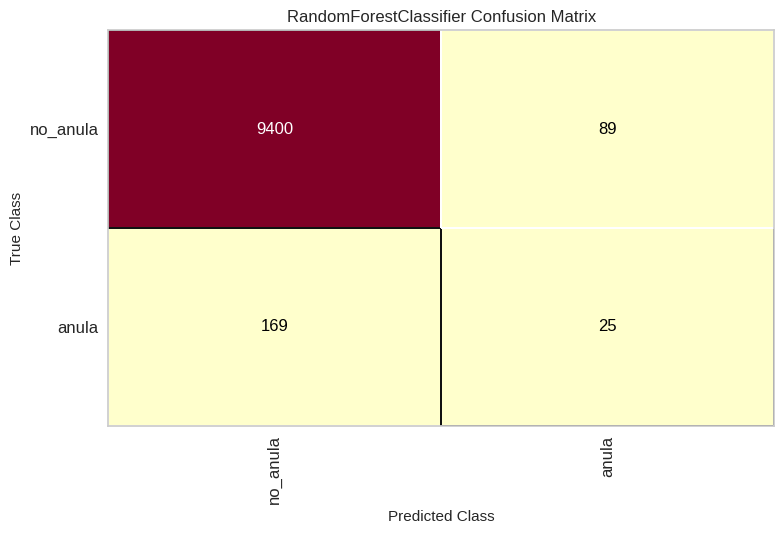

<Figure size 800x550 with 0 Axes>

In [48]:
confusion_matrix(
    best_model,
    X_train, y_train, X_test, y_test,
    classes=['no_anula', 'anula'])
plt.tight_layout()

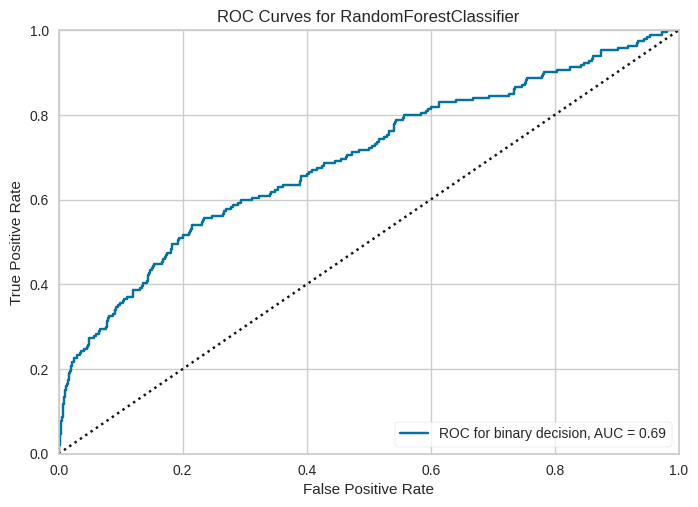

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=True, classes=['no anula', 'anula'],
       estimator=RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_leaf=9,
                                        min_samples_split=19,
                                        n_estimators=265),
       macro=False, micro=False, per_class=False)

In [49]:
roc_auc(best_model, X_train, y_train, X_test=X_test, y_test=y_test, classes=['no anula', 'anula'], binary=True)

Y la curva precision-recall

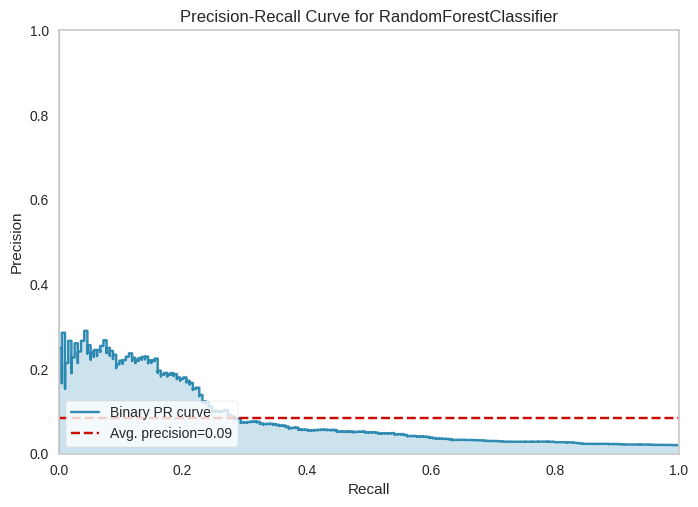

In [50]:
viz = precision_recall_curve(best_model, X_train, y_train, X_test, y_test)

#### XGBoost

Probamos también con un modelo XGBoost ya que suelen tener buen rendimiento en problemas de clasificación. Al igual que antes, buscamos los hiperparámetros óptimos mediante una búsqueda aleatorizada y eligiendo F1 como métrica.

In [53]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)


param_dist = {
    'n_estimators': randint(100, 500),      
    'max_depth': randint(3, 15),            
    'learning_rate': uniform(0.01, 0.3),    
    'subsample': uniform(0.5, 0.5),         
    'colsample_bytree': uniform(0.5, 0.5),  
    'gamma': uniform(0, 5),                 
    'reg_lambda': uniform(0, 10),           
    'reg_alpha': uniform(0, 10)             
}


random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,            
    scoring='f1',    
    cv=5,                 
    n_jobs=-1           
)


random_search.fit(X_train, y_train)


print("Mejores parámetros:", random_search.best_params_)

Mejores parámetros: {'colsample_bytree': 0.5099351598324335, 'gamma': 2.395956050837578, 'learning_rate': 0.028095380535047808, 'max_depth': 13, 'n_estimators': 265, 'reg_alpha': 8.930394666973037, 'reg_lambda': 3.3830835448703134, 'subsample': 0.9285647388148488}


In [54]:
best_xgb = random_search.best_estimator_
print(f"Hiperparámetros óptimos: {random_search.best_params_}")

Hiperparámetros óptimos: {'colsample_bytree': 0.5099351598324335, 'gamma': 2.395956050837578, 'learning_rate': 0.028095380535047808, 'max_depth': 13, 'n_estimators': 265, 'reg_alpha': 8.930394666973037, 'reg_lambda': 3.3830835448703134, 'subsample': 0.9285647388148488}


In [55]:
y_pred = best_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy on test set: 0.9703604254879686
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      9489
           1       0.20      0.15      0.17       194

    accuracy                           0.97      9683
   macro avg       0.59      0.57      0.58      9683
weighted avg       0.97      0.97      0.97      9683



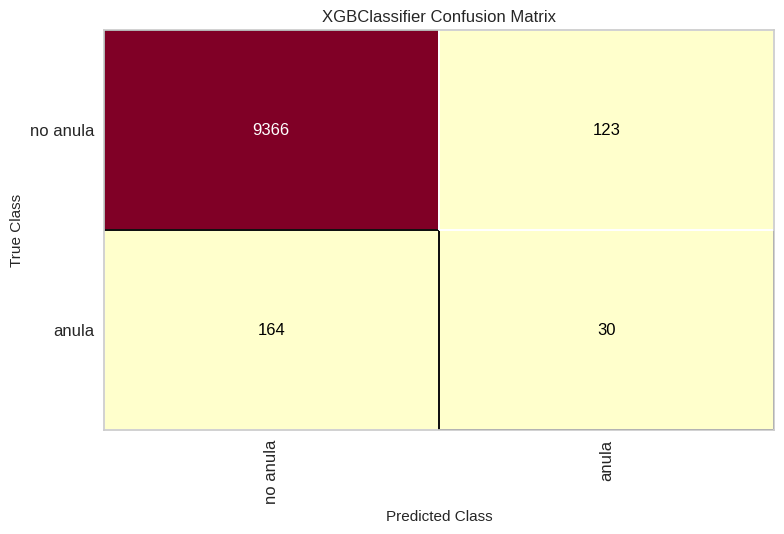

<Figure size 800x550 with 0 Axes>

In [56]:
confusion_matrix(
    best_xgb,
    X_train, y_train, X_test, y_test,
    classes=['no anula', 'anula'])
plt.tight_layout()

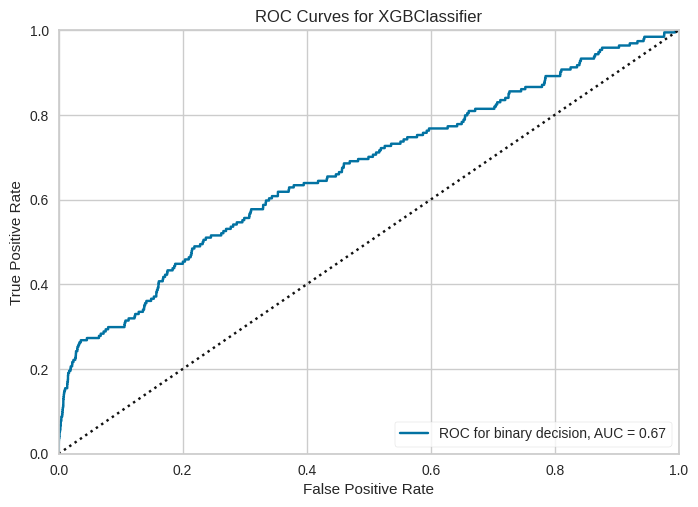

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=True, classes=['0', '1'],
       estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5099351598324335, device=None,
                               early_stopping_rounds=None,
                               enable_categorica...
                               interaction_constraints=None,
                               learning_rate=0.028095380535047808, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=13,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=265,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...),
       macro=False, micro=False, per_class=False)

In [57]:
roc_auc(best_xgb, X_train, y_train, X_test=X_test, y_test=y_test, classes=['0', '1'], binary=True)

Podemos comprobar que en la métrica F1 de la clase positiva tiene un rendimiento ligeramente superior al random forest.

#### Regresión logística

Por último, probamos un modelo de regresión logística. En este caso, debemos **normalizar** los datos puesto que utilizaremos regularización L1/l2 y queremos evitar que los valores más grandes sean más penalizados.

In [59]:
# modelo base 
logreg = LogisticRegression()

# Crear el pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalización de los datos
    ('logreg', logreg)  
])


In [60]:
param_dist = {
    'logreg__C': loguniform(1e-4, 1e4),  
    'logreg__solver': ['liblinear', 'lbfgs', 'saga'],  
    'logreg__max_iter': [100, 200, 300],  
    'logreg__penalty': ['l1', 'l2'],  
    'logreg__class_weight': ['balanced']  
}

In [61]:
# Configurar el RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,  
    param_distributions=param_dist,
    n_iter=20,  
    scoring='f1',  
    cv=5,  
    n_jobs=-1,  
    random_state=42  
)

# Entrenamiento
random_search.fit(X_train, y_train)

/home/dell/.local/share/virtualenvs/pythonProject-yKLWcwea/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dell/.local/share/virtualenvs/pythonProject-yKLWcwea/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dell/.local/share/virtualenvs/pythonProject-yKLWcwea/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dell/.local/share/virtualenvs/pythonProject-yKLWcwea/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dell/.local/share/virtualenvs/pythonProject-yKLWcwea/lib/python3.9/site-packages/sklearn/linear_model/_sag

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('logreg', LogisticRegression())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'logreg__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f615e6da820>,
                                        'logreg__class_weight': ['balanced'],
                                        'logreg__max_iter': [100, 200, 300],
                                        'logreg__penalty': ['l1', 'l2'],
                                        'logreg__solver': ['liblinear', 'lbfgs',
                                                           'saga']},
                   random_state=42, scoring='f1')

In [62]:
best_lr = random_search.best_estimator_
print("Mejores hiperparámetros encontrados:", random_search.best_params_)

Mejores hiperparámetros encontrados: {'logreg__C': 0.00012767906371238518, 'logreg__class_weight': 'balanced', 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}


In [63]:
y_pred = best_lr.predict(X_test)

# Evaluacion
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy on test set: 0.7538985851492306
              precision    recall  f1-score   support

           0       0.99      0.76      0.86      9489
           1       0.04      0.51      0.08       194

    accuracy                           0.75      9683
   macro avg       0.51      0.63      0.47      9683
weighted avg       0.97      0.75      0.84      9683



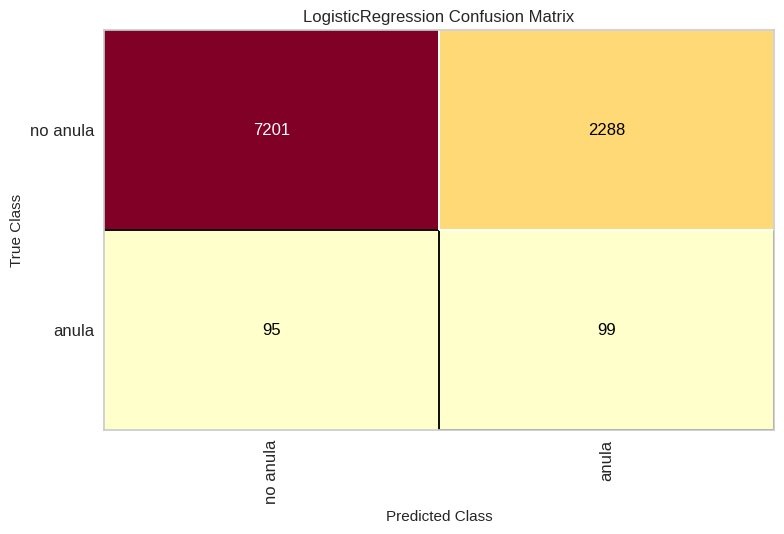

<Figure size 800x550 with 0 Axes>

In [64]:
confusion_matrix(
    best_lr,
    X_train, y_train, X_test, y_test,
    classes=['no anula', 'anula'])
plt.tight_layout()

En resumen, atendiendo a la métrica F1, el mejor modelo sería el XGboost.

- Interpreta los valores SHAP de los 3 principales factores más importantes, asi como sus interacciones.

In [66]:
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_train)

In [71]:
print(shap_values.shape)

(38728, 38)


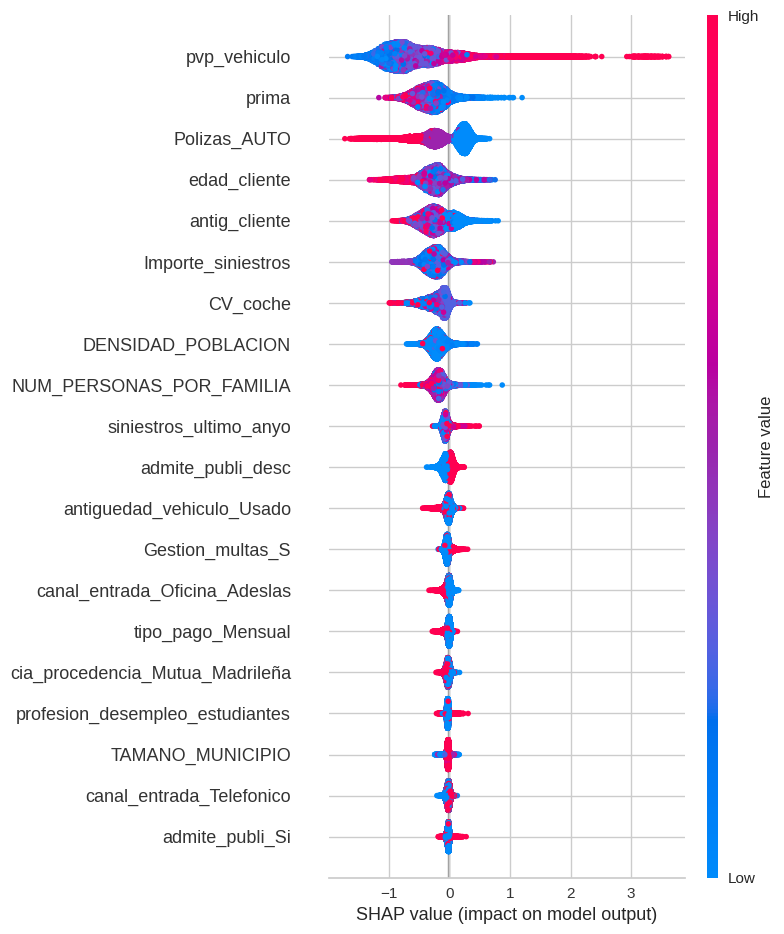

In [72]:
plt.figure(figsize=(12,8))
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)
plt.show()

Analicimos los valores SHAP para las 3 variables más importantes:

    - La variable pvp_vehiculo: valores altos tienen gran impacto en pocas predicciones y valores bajos poco impacto en muchas de las predicciones del  modelo
    - La variable prima tiene impacto reducido en muchas de las predicciones del modelo
    - La variable polizas_AUTO: valores bajos tienen gran impacto en algunas predicciones.

Interacciones entra las variables

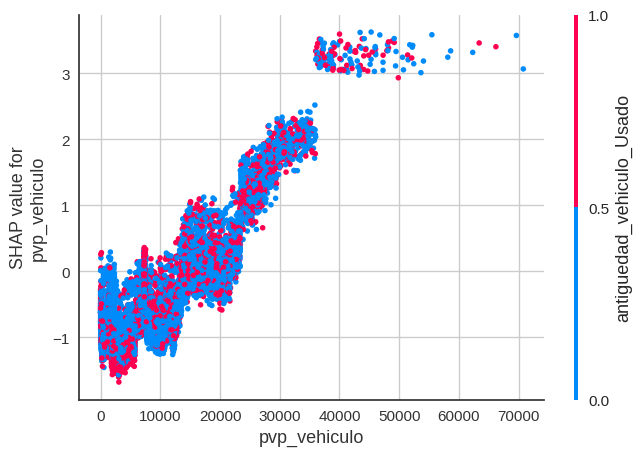

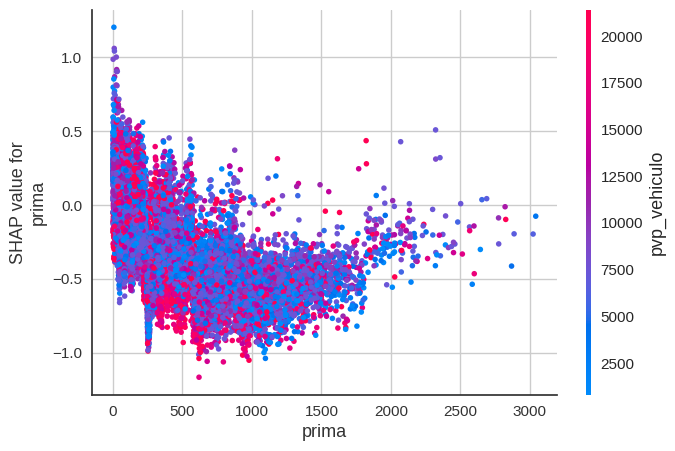

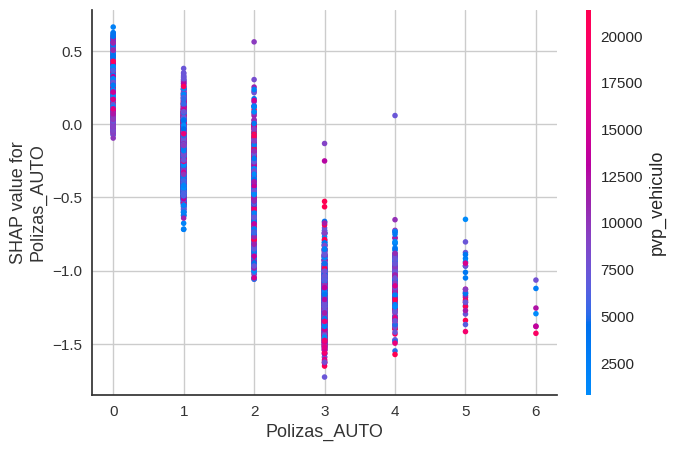

In [75]:
for name in ['pvp_vehiculo', 'prima', 'Polizas_AUTO',]:
    shap.dependence_plot(name, shap_values.values, X_train)

- El primer plot vemos que el precio del vehículo y la antigüedad tienen una tendencia ascendente con los valores SHAP, por lo que según aumenta el precio aumenta la probablidad de abandono.
- El segundo plot muestra una relación no lineal entre prima y precio del vehículo que disminuye ligeramente la probabilidad de abandono según el modelo.
- El último plot refleja que es más probable que abandonen clientes con menos pólizas contratadas.

- Explica que métricas has usado para determinar que el modelo es apropiado

Como se dijo anteriormente, elegimos la métrica f1-score porque por un lado queremos evitar falsos negativos para no perder clientes que podríamos retener pero por otro lado tenemos un presupuesto limitado de incentivos por lo que no podemos derrochar recursos enviando incentivos a clientes que finalmente no abandonan la compañía.

El F1-score busca un equilibrio entre estos dos objetivos

Aunque, en realidad, para tener un modelo óptimo para nuestro caso deberíamos definir una métrica que tuviese en cuenta el benificio obtenido por la empresa:
Beneficio Neto=(TP×(prima-Incentivo))−(FP×Incentivo)−(FN×prima).

El objetivo sería maximizar esa variable.

- Que punto de corte has elegido y explica porque crees que sería el mas apropiado para este caso

El umbral predeterminado (0.5) puede no ser óptimo para maximizar el beneficio neto, por lo que buscamos el umbral óptimo

In [77]:
def calcular_f1_por_umbral(y_true, y_probs, umbrales=np.linspace(0, 1, 100)):
    f1_scores = []
    precision_scores = []
    recall_scores = []

    for umbral in umbrales:
        y_pred = (y_probs >= umbral).astype(int)
        f1 = f1_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        
        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)

    max_idx = np.argmax(f1_scores)
    umbral_optimo = umbrales[max_idx]
    max_f1 = f1_scores[max_idx]

    # Gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(umbrales, f1_scores, label='F1-score', color='blue')
    plt.plot(umbrales, precision_scores, label='Precisión', color='green', linestyle='--')
    plt.plot(umbrales, recall_scores, label='Recall', color='red', linestyle='--')
    
    # Punto óptimo
    plt.scatter(umbral_optimo, max_f1, color='red', zorder=5)
    plt.text(umbral_optimo + 0.02, max_f1 - 0.02, 
             f'Óptimo: {umbral_optimo:.2f}\nF1: {max_f1:.2f}', 
             ha='left', va='top')
    
    plt.title('Métricas por Umbral de Clasificación')
    plt.xlabel('Umbral')
    plt.ylabel('Puntuación')
    plt.legend()
    plt.grid(True)
    plt.show()

    return umbral_optimo, max_f1, f1_scores, precision_scores, recall_scores

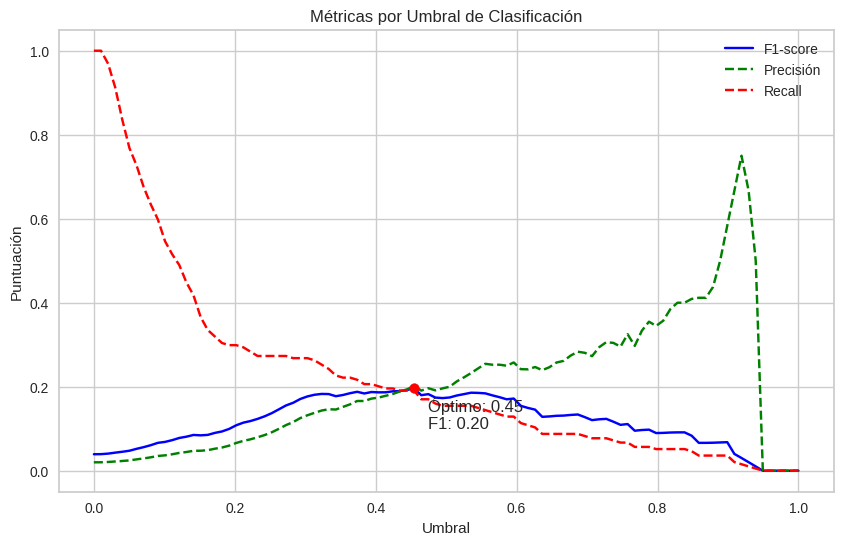

Umbral óptimo: 0.45
F1-score máximo: 0.20


In [78]:
y_probs = best_xgb.predict_proba(X_test)[:, 1]

# Calcular y graficar
umbral_optimo, max_f1, f1, precision, recall = calcular_f1_por_umbral(y_test, y_probs)

print(f"Umbral óptimo: {umbral_optimo:.2f}")
print(f"F1-score máximo: {max_f1:.2f}")

- Presentar diferentes propuestas de a cuantos, y a que clientes enviarías el incentivo de 50 euros y las ventajas/desventajas de cada una, así como el gasto esperado en incentivos, razonando las respuestas.

Propuesta 1

Se envía el incentivo a todos los clientes cuya probabilidad de no renovar (según el modelo) es mayor o igual a 45%.

Ventajas:
- Se cubre el grupo con más riesgo de churn.
- Aumenta la retención en la mayoría de los clientes en riesgo.

Desventajas:
- Es una estrategia costosa.
- Se enviará el incentivo a clientes que quizás no se vayan a ir de todos modos.

In [80]:
# Filtrar clientes con churn >= 0.45
clientes_en_riesgo = X_test[y_probs >= 0.45].copy()  
clientes_en_riesgo["prob_churn"] = y_probs[y_probs >= 0.45]  

print(f"Gasto en incentivos: {clientes_en_riesgo.shape[0]*50}"+"€")

Gasto en incentivos: 9300€


Propuesta 2

Se envía solo a los clientes con una probabilidad mayor o igual a 70% de no renovar.

Ventajas:
- Se concentra el incentivo en los clientes con mayor riesgo.
- Se reduce el gasto en comparación con la estrategia anterior.

Desventajas:
- Se pueden perder clientes con probabilidades intermedias de churn (50%-69%).
- Puede que algunos clientes en este grupo no se queden a pesar del incentivo.

In [81]:

clientes_en_riesgo = X_test[y_probs >= 0.7].copy()  
clientes_en_riesgo["prob_churn"] = y_probs[y_probs >= 0.7]  

print(f"Gasto en incentivos: {clientes_en_riesgo.shape[0]*50}"+"€")

Gasto en incentivos: 2800€


Propuesta 3

Se filtran clientes con alto valor (ej. con más de 5 años de antigüedad o pólizas de alto monto) y riesgo de churn ≥ 50%.

Ventajas:
- Asegura que el dinero se invierta en clientes rentables.
- Mejora la retención de los clientes más valiosos para la empresa.

Desventajas:
- Puede ignorar clientes nuevos que podrían volverse rentables con el tiempo.
- Puede que los clientes menos valiosos sientan que no reciben un trato justo.

In [82]:
clientes_en_riesgo = X_test[y_probs >= 0.5].copy()  
clientes_en_riesgo.loc[clientes_en_riesgo['antig_cliente']>5].shape[0]*50
print(f"Gasto en incentivos: {clientes_en_riesgo.loc[clientes_en_riesgo['antig_cliente']>5].shape[0]*50}"+"€")

Gasto en incentivos: 3650€


Propuesta 4

Se analiza el histórico de clientes que han respondido bien a incentivos en el pasado y se les prioriza dentro del grupo de churn ≥ 50%.

Ventajas:
- Mayor probabilidad de éxito con menor gasto.
- Se evita desperdiciar incentivos en clientes que probablemente igual se irán.

Desventajas:
- Requiere tener datos históricos sobre incentivos previos.
- Puede que algunos clientes nuevos o diferentes también respondan bien, pero sean excluidos.

- Que perfiles de clientes es el que más riesgo tiene de fuga? Y cuales menos?

In [83]:
# Crear un DataFrame con X_test y las probabilidades de churn
df_test = X_test.copy()
df_test["prob_churn"] = y_probs

# Definir grupos de riesgo
high_risk = df_test[df_test["prob_churn"] >= 0.7]  # Alto riesgo (probabilidad >= 70%)
low_risk = df_test[df_test["prob_churn"] <= 0.3]   # Bajo riesgo (probabilidad <= 30%)

# Mostrar el número de clientes en cada grupo
print(f"Clientes de alto riesgo: {high_risk.shape[0]}")
print(f"Clientes de bajo riesgo: {low_risk.shape[0]}")

Clientes de alto riesgo: 56
Clientes de bajo riesgo: 9282


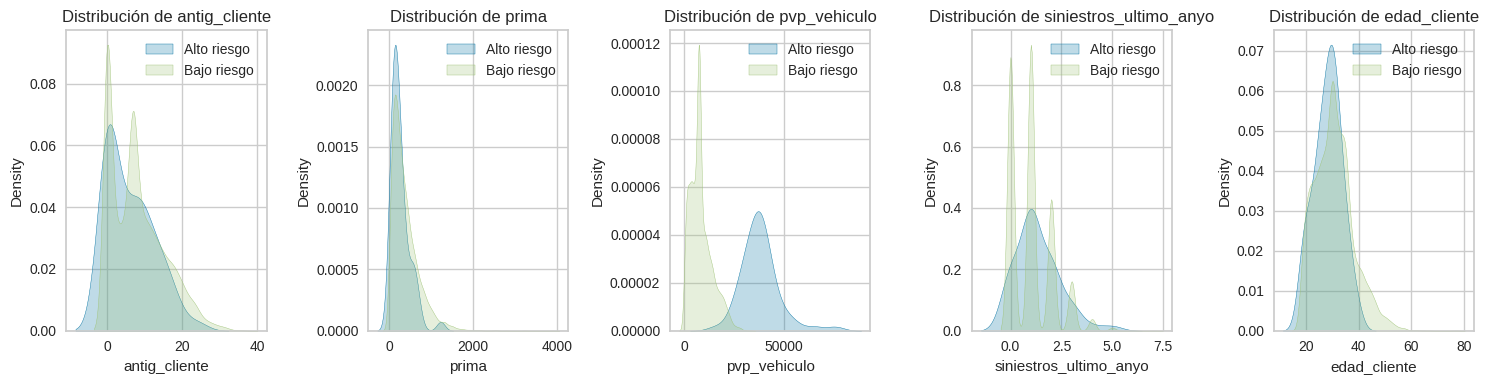

In [84]:
features = ["antig_cliente", "prima", "pvp_vehiculo", "siniestros_ultimo_anyo", "edad_cliente"]

fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i, feature in enumerate(features):
    sns.kdeplot(high_risk[feature], label="Alto riesgo", ax=axes[i], shade=True)
    sns.kdeplot(low_risk[feature], label="Bajo riesgo", ax=axes[i], shade=True)
    axes[i].set_title(f"Distribución de {feature}")
    axes[i].legend()

plt.tight_layout()
plt.show()

Parece que el perfil de cliente que más abandona es el que tiene mayor antigüedad como cliente, algñun siniestro el último año y el precio de su vehículo es superior a 30.000€.

Por contra, los clientes mas fieles son los más nuevos, de mñas edad, con vehículos más económicos y han tenido uno o ningún siniestro el último año.

In [ ]:
Esta información podría servir para:
- Personalizar incentivos: Clientes de alto riesgo pueden recibir descuentos o beneficios exclusivos.
- Optimizar precios: Revisar tarifas para clientes que pagan más y podrían irse.
- Mejorar la experiencia: Reducir el churn con mejor servicio o atención personalizada

# Ejercicio 2

- Aplica la técnica más apropiada para intentar mejorar el desbalanceo en el modelo anterior

Aplicaremos una técnica de sobremuestreo sobre la clase minoritaría, para que pase a representar el 50% de la clase mayoritaria.

El sobremuestreo se aplica siempre sobre el conjunto de train nunca de test para evitar el data leakage: Si se aplica sobremuestreo antes de dividir los datos, las muestras sintéticas contaminarán el conjunto de prueba, generando una evaluación irreal.
El conjunto de prueba debe reflejar la distribución desbalanceada del mundo real para evaluar correctamente el modelo.

In [85]:
smote = SMOTE(sampling_strategy=.5, random_state=42)  
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

- Después realiza un modelo de ensamblaje  que consideres más apropiado

Primero volvemos a optimizar los modelos con las muestras balanceadas y realizamos ensamblaje por ponderación:

In [87]:
# Hiperparámetros para Random Forest
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Hiperparámetros para XGBoost
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Hiperparámetros para Regresión Logística
param_dist = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],  
    'logreg__solver': ['lbfgs'],  
    'logreg__max_iter': [100, 200, 300],  
    'logreg__penalty': ['l2'] 
   }

In [88]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(rf, param_dist_rf, n_iter=10, scoring='f1', cv=3, n_jobs=-1)
random_search_rf.fit(X_resampled, y_resampled)
best_rf = random_search_rf.best_estimator_

# XGBoost
xgb = XGBClassifier(random_state=42)
random_search_xgb = RandomizedSearchCV(xgb, param_dist_xgb, n_iter=10, scoring='f1', cv=3, n_jobs=-1)
random_search_xgb.fit(X_resampled, y_resampled)
best_xgb = random_search_xgb.best_estimator_

# Regresión Logística
lr = LogisticRegression()
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('logreg', lr)  
])

random_search_lr = RandomizedSearchCV(
    estimator=pipeline,  
    param_distributions=param_dist,  
    n_iter=10,  
    scoring='f1',  
    cv=3,  
    n_jobs=-1  
)

random_search_lr.fit(X_resampled, y_resampled)
best_lr = random_search_lr.best_estimator_

In [89]:
voting_clf = VotingClassifier(
    estimators=[('rf', best_rf), ('xgb', best_xgb), ('lr', best_lr)], 
    voting='soft'
)
voting_clf.fit(X_resampled, y_resampled)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=15,
                                                     min_samples_leaf=4,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lr',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('logreg',
                                               LogisticRegression(C=1,
                                                                  max_iter=200))]))],
                 voting='soft')

In [90]:
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9489
           1       0.36      0.05      0.08       194

    accuracy                           0.98      9683
   macro avg       0.67      0.52      0.54      9683
weighted avg       0.97      0.98      0.97      9683



Al evaluar el modelo en la métrica F1 de la clase positiva obtenemos peor resultado.

- Aplica las técnicas adicionales que consideres que incrementen más la precisión del modelo.

Probaremos el ensamblaje apilado para mejorar la precisión, con un meta-modelo de regresión logística.

In [91]:
base_models = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('lr', best_lr)
]

# Meta-modelo: Regresión Logística
stack = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
stack.fit(X_resampled, y_resampled)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=15,
                                                       min_samples_leaf=4,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_typ...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=300, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('lr',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=1,
                                                                    max_iter=200))]))],
                   final_estimator=LogisticRegression())

In [92]:
y_pred_stack = stack.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9489
           1       0.36      0.05      0.08       194

    accuracy                           0.98      9683
   macro avg       0.67      0.52      0.54      9683
weighted avg       0.97      0.98      0.97      9683



obtenemos un resultado similar.

- Cual es la probabilidad media real y cual es la estimada antes y despues de aplicar las mejoras? 

In [94]:

print(f"prob antes: {voting_clf.predict_proba(X_test)[:, 1].mean()}", 
f"prob después: {stack.predict_proba(X_test)[:, 1].mean()}",
f"prob real: {y_test.mean()}")


prob antes: 0.10037822296940037 prob después: 0.0191932618759061 prob real: 0.02003511308478777


- Aplica la técnica que consideres apropiada para asemejar la probabilidad media real y la estimada

In [95]:
calibrated_model = CalibratedClassifierCV(stack, method='sigmoid', cv=5)  # Platt Scaling
calibrated_model.fit(X_resampled, y_resampled)

# Obtener las nuevas probabilidades calibradas
y_pred_probs_calibrated = calibrated_model.predict_proba(X_test)[:, 1]
print("Probabilidad media predicha antes:", stack.predict_proba(X_test)[:, 1].mean())
print("Probabilidad media predicha después:", y_pred_probs_calibrated.mean())

Probabilidad media predicha antes: 0.0191932618759061
Probabilidad media predicha después: 0.01512366390105412


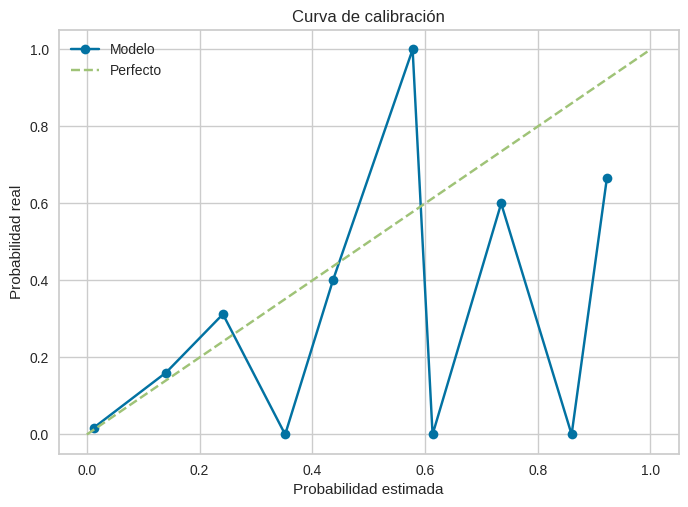

In [96]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_probs_calibrated, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label="Modelo")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfecto")
plt.xlabel("Probabilidad estimada")
plt.ylabel("Probabilidad real")
plt.legend()
plt.title("Curva de calibración")
plt.show()

Podemos observar las diferencias entre prob real y estimada para los clientes a los que el modelo asigna alta prob de  abandono

- Por ultimo, contruye la variable beneficio= prima-importe de siniestros y vuelve a presentar diferentes propuestas de a que clientes y cuantos enviarias el incentivo. Y si cambiarias el importe del incentivo

Propuesta 1:

Clientes con alto riesgo de churn (probabilidad predicha ≥ 0.5).
Clientes con beneficio positivo (prima > importe de siniestros).
 Pros y Contras:
- Evita incentivar clientes que generan pérdidas.
- Maximiza el retorno del incentivo.
- Se podría perder algún cliente valioso que haya tenido un siniestro puntual.

Propuesta 2:

Clientes con alto riesgo de churn (≥ 0.5).

Clientes con beneficio alto (ejemplo: en el top 25% de beneficio).

Incentivo variable según beneficio:

Clientes con beneficio alto (top 10%) → 75€

Clientes con beneficio medio (10%-25%) → 50€

Clientes con beneficio bajo pero positivo → 25€

Pros y Contras:
- Maximiza la retención de clientes más valiosos.
- Reduce el gasto en clientes menos rentables.
- Más complejidad en la implementación.

Propuesta 3:

Clientes con probabilidad de renovación cercana a 50% (es decir, indecisos).

Beneficio positivo o ligeramente negativo (pero con buena antigüedad y engagement).
Pros y Contras:
- Evita malgastar incentivos en clientes que probablemente se vayan de todas formas.
- Potencia la conversión en clientes que están indecisos.
- Puede dejar afuera clientes de alto beneficio que sí se podrían haber retenido con un mayor incentivo.

 Si el churn estimado es muy alto (>70%), un incentivo de 50€ podría ser insuficiente. Se podría probar con 75€ o más para clientes premium.
- Si los clientes son muy sensibles al precio, incluso 25€ podría ser suficiente en algunos casos.
- Una opción híbrida es testear diferentes importes con A/B testing.

En este caso, la propuesta 2 sería una nopción interesante para maximizar beneficio de la empresa y no tener un gasto elevado en incentivos

In [98]:
X_beneficio = X_test.copy()

In [99]:
y_probs_stack=stack.predict_proba(X_test)[:, 1]
X_beneficio['churn_rate'] = y_probs_stack
X_beneficio['beneficio'] = X_beneficio['prima']-X_beneficio['Importe_siniestros']

In [100]:
clientes_en_riesgo = X_beneficio[y_probs >= 0.5]

In [101]:
clientes_en_riesgo.beneficio.quantile(.75)

293.475508314

In [102]:
clientes_en_riesgo.beneficio.quantile(.9)

496.0478447134001

Enviaríamos un incentivo intermedio (50€) a aquellos clientes cuyo beneficio esté entre 294€ y 496€ y un incentivo extra (75€) a los clientes cuyo beneficio sea igual o superior a 496€.